In [118]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Load your dataset into a Pandas DataFrame
data = pd.read_excel('../data/包含区域信息_cleaned.xlsx')
scaler = MinMaxScaler()
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data['Basics.Location'] = data['Basics.Location'].str.split(',').str[-1]
# print(data.dtypes)

# data = data.loc[0:, ['Basics.Length (ft)',
#  'Propulsion.TotalPower (hp)',
#  'Specifications.Accommodations.DoubleBerths',
#  'Specifications.Accommodations.Cabins',
#  'Specifications.Accommodations.Heads',
#  'Propulsion.EngineYear',
#  'Specifications.Speed&Distance.CruisingSpeed (kn)',
#  'Specifications.Speed&Distance.MaxSpeed (kn)',
#  'Specifications.Dimensions.LengthOnDeck (ft)',
#  'Specifications.Dimensions.LengthAtWaterline (ft)',
#  'Specifications.Dimensions.MaxBridgeClearance (ft)', 'Price', 'Basics.Location']]



# One-hot encode categorical features

# 查找所有类型为object的列
object_columns = data.select_dtypes(include=['object']).columns

# 对object类型的列进行独热编码
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(data[object_columns])

# 将独热编码后的列合并到原始数据中，删除原始的object类型列
encoded_columns_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(object_columns))
data = pd.concat([data.drop(object_columns, axis=1), encoded_columns_df], axis=1)

print(data.dtypes)


Price-1                                                       float64
New                                                              bool
Basics.Year                                                   float64
Basics.Length (ft)                                            float64
Basics.HullWarranty (years)                                   float64
                                                               ...   
Make-Model_Zuanelli-Zuanelli Z401                             float64
Make-Model_cantiere del sole-Cantiere del Sole SOLEADA 141    float64
Make-Model_de Haas Shipyard-60' Motorsailer 1968/94           float64
Make-Model_finnsailer-35                                      float64
Make-Model_jouete-1300                                        float64
Length: 27924, dtype: object


In [119]:
# Define the features and label
X = data.drop(columns=['Price'])
y = data['Price']

print(X.shape)
print(y.shape)

(11239, 27923)
(11239,)


In [120]:
# split the train set and the test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [112]:
print(X.dtypes)
print(X_test.shape)
print(y.dtypes)

Basics.Length (ft)                            float64
Propulsion.TotalPower (hp)                    float64
Specifications.Accommodations.DoubleBerths    float64
Specifications.Accommodations.Cabins          float64
Specifications.Accommodations.Heads           float64
                                               ...   
Basics.Location_Thailand                      float64
Basics.Location_Tunisia                       float64
Basics.Location_Turkey                        float64
Basics.Location_United Kingdom                float64
Basics.Location_United States                 float64
Length: 141, dtype: object
(2248, 141)
float64


In [121]:
import xgboost as xgb
import numpy as np
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, eta = 0.1)
model.fit(X_train, np.log(y_train))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [122]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
mse = mean_squared_error((y_test), y_pred)

print(y_test.shape)
print(f"Mean Squared Error: {mse}")


(2248,)
Mean Squared Error: 5.482223849577555e-08


In [123]:
# R^2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print("R^2 score:", r2)

R^2 score: 0.999900721367861


In [124]:
import shap

# Initialize the explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(2248, 27923)


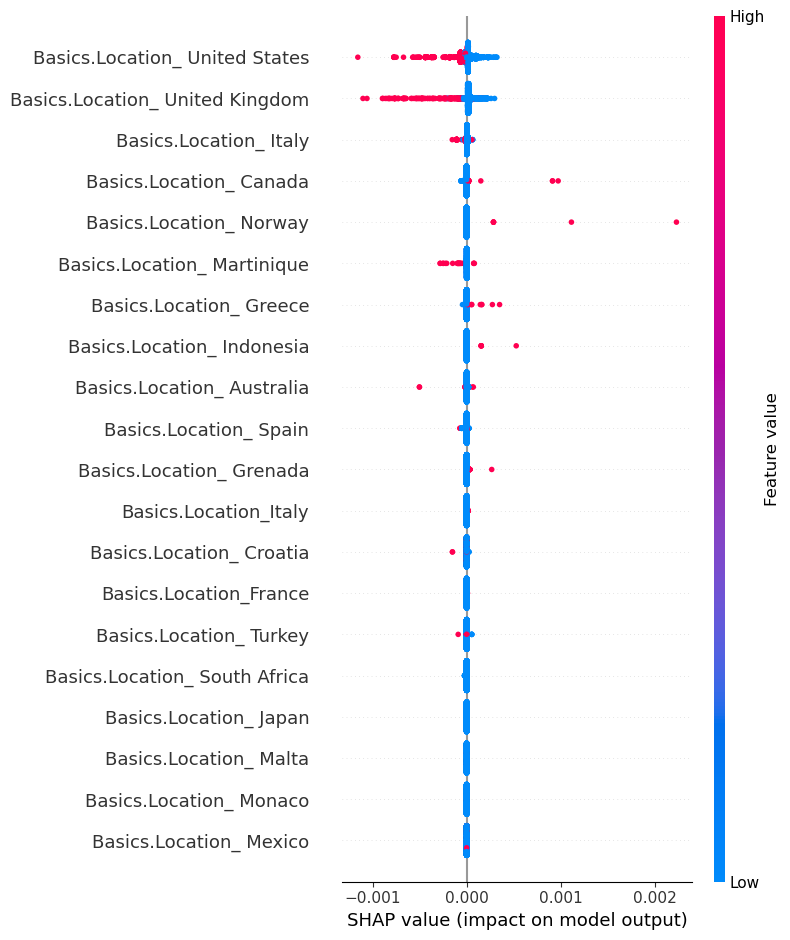

In [125]:
# Filter the SHAP values for the 'Geographic Region' features
print(X_test.shape)
geographic_region_shap_values = shap_values[:, X_test.columns.str.startswith('Basics.Location')]

# Plot the summary plot for the 'Geographic Region' features
shap.summary_plot(geographic_region_shap_values.values, X_test.loc[:, X_test.columns.str.startswith('Basics.Location')])
